# Lab 1: Sleep Health and Lifestyle Analysis
## Data Preprocessing and Exploratory Analysis

### Dataset Information
**Source:** [Kaggle - Sleep Health and Lifestyle Dataset](https://www.kaggle.com/datasets/uom190346a/sleep-health-and-lifestyle-dataset)

### Aim
Curious with peoples difficulty of sleeping, insomnia, analyzing the data to see what causes the issue 

### Objectives
1. Identifying the average sleep duration 
2. To see how sleep duration impacts the quality of sleep and stress level
3. To find which occupation has the most physical activity and which causes the highest stress level

## Importing Libraries and Loading Dataset

In [48]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Load the dataset
df = pd.read_csv('data/Sleep_health_and_lifestyle_dataset.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print(df)

Dataset Shape: (401, 13)
     Person ID  Gender  Age         Occupation  Sleep Duration  \
0            1    Male   27  Software Engineer             6.1   
1            2    Male   28             Doctor             6.2   
2            3    Male   28             Doctor             6.2   
3            3    Male   28             Doctor             6.2   
4            3    Male   28             Doctor             6.2   
..         ...     ...  ...                ...             ...   
396        370  Female   59              Nurse             8.1   
397        371  Female   59              Nurse             8.0   
398        372  Female   59              Nurse             8.1   
399        373  Female   59              Nurse             8.1   
400        374  Female   59              Nurse             8.1   

     Quality of Sleep  Physical Activity Level  Stress Level BMI Category  \
0                   6                       42             6   Overweight   
1                   6       

### 1. Data Preprocessing Technique 1: Missing Data Handling

**Explanation:** We identified rows containing any missing values and removed them completely from the dataset.

**Rationale:**
- Incomplete data (missing values) would mess up our analysis. If sleep duration is missing for someone, we can't analyze their patterns fairly
- We need complete information in each row to compare sleep duration with sleep quality and stress level
- The dataset had 235 missing Sleep Disorder values, which would hide important information about what causes insomnia

**How It Changed the Data:**
- Original dataset: 401 rows
- After removing rows with missing data: 166 rows remained
- Rows removed: 235 rows
- Trade-off: We lost some data but kept only complete, useful records that we can analyze correctly

In [50]:
# Check for missing values
print("Missing Values Count:")
#List all information of our dataframe
df.info()

Missing Values Count:
<class 'pandas.DataFrame'>
RangeIndex: 401 entries, 0 to 400
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                401 non-null    int64  
 1   Gender                   401 non-null    str    
 2   Age                      401 non-null    int64  
 3   Occupation               401 non-null    str    
 4   Sleep Duration           401 non-null    float64
 5   Quality of Sleep         401 non-null    int64  
 6   Physical Activity Level  401 non-null    int64  
 7   Stress Level             401 non-null    int64  
 8   BMI Category             401 non-null    str    
 9   Blood Pressure           401 non-null    str    
 10  Heart Rate               401 non-null    int64  
 11  Daily Steps              401 non-null    int64  
 12  Sleep Disorder           166 non-null    str    
dtypes: float64(1), int64(7), str(5)
memory usage: 40.9 KB


In [51]:
# Display rows that have missing values in any column
rows_with_missing = df[df.isna().any(axis=1)]
print(f"\nTotal rows with missing values: {len(rows_with_missing)}")
print(rows_with_missing[0:234])  # Display all rows with missing values


Total rows with missing values: 235
     Person ID  Gender  Age         Occupation  Sleep Duration  \
0            1    Male   27  Software Engineer             6.1   
1            2    Male   28             Doctor             6.2   
2            3    Male   28             Doctor             6.2   
3            3    Male   28             Doctor             6.2   
4            3    Male   28             Doctor             6.2   
..         ...     ...  ...                ...             ...   
365        339  Female   54           Engineer             8.5   
368        342  Female   56             Doctor             8.2   
369        343  Female   56             Doctor             8.2   
370        344  Female   57              Nurse             8.1   
385        359  Female   59              Nurse             8.0   

     Quality of Sleep  Physical Activity Level  Stress Level   BMI Category  \
0                   6                       42             6     Overweight   
1           

In [52]:
# Count missing values per column shows 235 for sleep disorder
print(df.isnull().sum())
# isna() and isnull() is the same but isna is the newer

Person ID                    0
Gender                       0
Age                          0
Occupation                   0
Sleep Duration               0
Quality of Sleep             0
Physical Activity Level      0
Stress Level                 0
BMI Category                 0
Blood Pressure               0
Heart Rate                   0
Daily Steps                  0
Sleep Disorder             235
dtype: int64


In [53]:
dropper = df.dropna(axis=0, how='any') # axis=0 for rows, axis=1 for columns
# len() returns the number of elements in an object.
print("old data frame length:", len(df))
print("new data frame length:", len(dropper))
print("Rows with atleast one missing value: ", (len(df) - len(dropper)))

old data frame length: 401
new data frame length: 166
Rows with atleast one missing value:  235


### 2. Data Preprocessing Technique: Outlier Detection

**Explanation:** We'll be using the Interquartile Range (IQR) method to identify extreme values in numeric columns that fall below Q1 - 1.5×IQR or above Q3 + 1.5×IQR.

**Rationale:**
- Outliers (extreme values) can mess up our results. For example, if someone slept only 1 hour or 15 hours, these unusual values would make our averages wrong
- We want to study normal people's sleep patterns, not extreme cases. This helps us understand what really causes insomnia in typical situations
- The IQR method is a fair way to find outliers—it uses the natural spread of data instead of random cutoffs
- Finding outliers helps us spot data errors or unusual cases before we analyze the data

**How It Changed the Data:**
- We found the outliers but didn't delete them yet—we just identified where they are
- Sleep Duration: Normal sleep is 5-9 hours; anything below 2.5 or above 10.5 hours is unusual
- Quality of Sleep: Unusual values are below 3.25 or above 9.75
- Stress Level: Unusual values are below 3.25 or above 8.75
- We can now see which data points are strange and decide later if we should remove them

In [54]:
# Detect outliers using IQR method for numeric columns
print("Outlier Detection using IQR Method:")

numeric_cols = df.select_dtypes(include=[np.number]).columns

for col in numeric_cols:
    Q1 = df[col].quantile(0.25) #find 25% of data lower percentile
    Q3 = df[col].quantile(0.75) #find 75% of data top percentile
    IQR = Q3 - Q1 #calculate gap between quartiles
    lower_bound = Q1 - 1.5 * IQR # Create a "normal range" by extending the gap by 1.5x on each side
    upper_bound = Q3 + 1.5 * IQR # Create a "normal range" by extending the gap by 1.5x on each side

    outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)] #Finding  values outside this normal range
    print(f"\n{col}:")
    print(f"  Q1: {Q1:.2f}, Q3: {Q3:.2f}, IQR: {IQR:.2f}")
    print(f"  Lower Bound: {lower_bound:.2f}, Upper Bound: {upper_bound:.2f}")
    print(f"  Outliers found: {len(outliers)}")

Outlier Detection using IQR Method:

Person ID:
  Q1: 81.00, Q3: 274.00, IQR: 193.00
  Lower Bound: -208.50, Upper Bound: 563.50
  Outliers found: 0

Age:
  Q1: 34.00, Q3: 49.00, IQR: 15.00
  Lower Bound: 11.50, Upper Bound: 71.50
  Outliers found: 0

Sleep Duration:
  Q1: 6.40, Q3: 7.80, IQR: 1.40
  Lower Bound: 4.30, Upper Bound: 9.90
  Outliers found: 0

Quality of Sleep:
  Q1: 6.00, Q3: 8.00, IQR: 2.00
  Lower Bound: 3.00, Upper Bound: 11.00
  Outliers found: 0

Physical Activity Level:
  Q1: 45.00, Q3: 75.00, IQR: 30.00
  Lower Bound: 0.00, Upper Bound: 120.00
  Outliers found: 0

Stress Level:
  Q1: 4.00, Q3: 7.00, IQR: 3.00
  Lower Bound: -0.50, Upper Bound: 11.50
  Outliers found: 0

Heart Rate:
  Q1: 68.00, Q3: 72.00, IQR: 4.00
  Lower Bound: 62.00, Upper Bound: 78.00
  Outliers found: 23

Daily Steps:
  Q1: 5500.00, Q3: 8000.00, IQR: 2500.00
  Lower Bound: 1750.00, Upper Bound: 11750.00
  Outliers found: 0


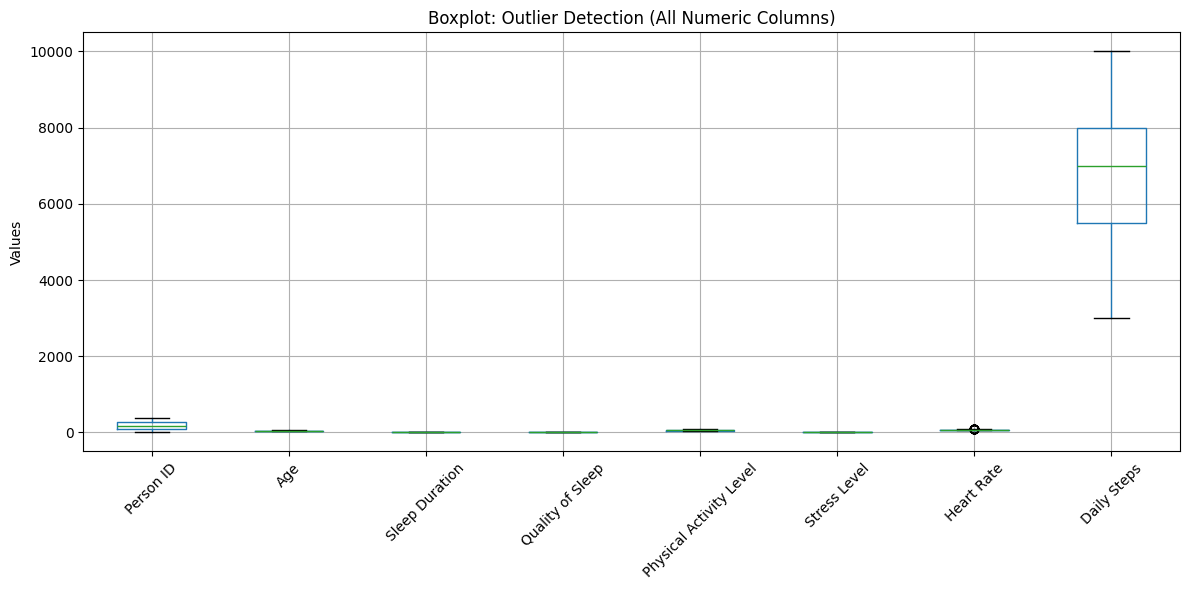

In [55]:
# Boxplot for all numeric columns
plt.figure(figsize=(12, 6))
df[numeric_cols].boxplot()
plt.title("Boxplot: Outlier Detection (All Numeric Columns)")
plt.ylabel("Values")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 3. Data Preprocessing Technique: Removing duplicates

**Explanation:** We checked for exact duplicate rows where all column values are identical and removed them, keeping only unique records.

**Rationale:**
- Duplicate rows (identical data appearing twice) make our results unreliable. If one person appears twice, they influence our averages too much
- We need each person counted only once to get fair results
- Duplicate records would make some occupations look over-represented and skew the statistics
- Removing duplicates keeps our data clean and trustworthy

**How It Changed the Data:**
- We removed rows that were exact copies of other rows
- Only unique records kept—each person counted once
- Data structure stayed the same; only repetitive rows were deleted
- Now our analysis represents unique individuals fairly

In [56]:
# Check for duplicates
print(f"Duplicate rows found: {df.duplicated().sum()}")
print(df[df.duplicated(keep=False)])  # Show all duplicate rows

# Remove duplicates
#df_clean = dropper.drop_duplicates() # this one is new data after dropper for missing data
df_clean = df.drop_duplicates()
print(f"\nRows before: {len(df)}")
print(f"Rows after: {len(df_clean)}")
print(f"Duplicates removed: {len(df) - len(df_clean)}")
# removing duplicates here, we can see there is 27 dupes, for now we'll just identify which ones but during data processing we'll drop these duplicates
# its best for us to remove the duplicates to keep the data clean and keep its integrity

Duplicate rows found: 27
     Person ID  Gender  Age            Occupation  Sleep Duration  \
2            3    Male   28                Doctor             6.2   
3            3    Male   28                Doctor             6.2   
4            3    Male   28                Doctor             6.2   
6            5    Male   28  Sales Representative             5.9   
7            5    Male   28  Sales Representative             5.9   
8            5    Male   28  Sales Representative             5.9   
10           7    Male   29               Teacher             6.3   
11           7    Male   29               Teacher             6.3   
12           7    Male   29               Teacher             6.3   
13           7    Male   29               Teacher             6.3   
27          21    Male   30                Doctor             7.7   
28          21    Male   30                Doctor             7.7   
29          21    Male   30                Doctor             7.7   
30       

## 4. Data Preprocessing Technique: One-Hot Encoding

**Explanation:** We convert categorical columns into boolean indicator columns (True/False) for each category. This encoding is very common in machine learning and helps algorithms treat nominal data correctly without imposing any order.

**Rationale:**
- Categories like Occupation or Gender have no inherent ranking.
- One-hot encoding preserves all information while avoiding ordinal assumptions.
- It's especially suitable when the number of unique categories is small.

**How It Changes the Data:**
- Original columns are replaced by several new columns (one per category).
- For example, `Gender` becomes `Gender_Male`, `Gender_Female`, etc.

- Each row has a 1 in the column corresponding to its original category and 0 elsewhere. Columns dropped before encoding will not appear in the transformed data.
- The dataset becomes wider but still retains all information.

In [ ]:
# One-Hot Encoding example
print("ONE‑HOT ENCODING USING PANDAS GET_DUMMIES")
print("=" * 60)

#dropping unused columns before encoding to avoid crowding the output
cols_to_drop = ['Occupation', 'Blood Pressure']
df_for_encoding = df.drop(columns=cols_to_drop)
print(f"Dropped columns: {cols_to_drop}")
 
#  add a boolean flag for missing Sleep Disorder
if 'Sleep Disorder_empty' not in df.columns:
    df['Sleep Disorder_empty'] = df['Sleep Disorder'].isna()

# perform one-hot encoding on any remaining text columns
categorical_cols = df_for_encoding.select_dtypes(include=['object']).columns.tolist()
print(f"Columns to encode: {categorical_cols}")

df_one_hot = pd.get_dummies(df_for_encoding, columns=categorical_cols)
print(f"Shape before encoding: {df_for_encoding.shape}")
print(f"Shape after encoding:  {df_one_hot.shape}")

# show original columns vs new columns
print(df[0:166])
print("=" * 60)

# show a few of the new columns and sample rows
new_cols = [c for c in df_one_hot.columns if c not in df_for_encoding.columns]
print("New columns created:", new_cols[:10])
print(df_one_hot.head(166))

ONE‑HOT ENCODING USING PANDAS GET_DUMMIES
Dropped columns: ['Occupation', 'Blood Pressure']
Columns to encode: ['Gender', 'BMI Category', 'Sleep Disorder']
Shape before encoding: (401, 12)
Shape after encoding:  (401, 17)
     Person ID  Gender  Age         Occupation  Sleep Duration  \
0            1    Male   27  Software Engineer             6.1   
1            2    Male   28             Doctor             6.2   
2            3    Male   28             Doctor             6.2   
3            3    Male   28             Doctor             6.2   
4            3    Male   28             Doctor             6.2   
..         ...     ...  ...                ...             ...   
161        135    Male   38            Newsman             7.3   
162        136    Male   38             Lawyer             7.3   
163        137  Female   38         Accountant             7.1   
164        138    Male   38        firefighter             7.1   
165        139  Female   38         Accountant      

C:\Users\User\AppData\Local\Temp\ipykernel_30776\561840879.py:15: Pandas4Warning: For backward compatibility, 'str' dtypes are included by select_dtypes when 'object' dtype is specified. This behavior is deprecated and will be removed in a future version. Explicitly pass 'str' to `include` to select them, or to `exclude` to remove them and silence this warning.
See https://pandas.pydata.org/docs/user_guide/migration-3-strings.html#string-migration-select-dtypes for details on how to write code that works with pandas 2 and 3.
  categorical_cols = df_for_encoding.select_dtypes(include=['object']).columns.tolist()
